In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py 
import json
import copy
from collections import OrderedDict
from lmfit import Model

from pygama.pargen.dsp_optimize import run_one_dsp
from pygama.pargen.dsp_optimize import run_grid
from pygama.pargen.dsp_optimize import ParGrid
from pygama.lgdo.lh5_store import LH5Store
import pygama.math.histogram as pgh
import pygama.math.peak_fitting as pgf


sys.path.insert(1, '../analysis/')
import processes.foundation as fd
import processes.fitModel as fM
import processes.histogramAction as hA


sto = LH5Store("../../data/raw/")

In [3]:
debug = False

hi = 50
lo = 40

runs = [x for x in range(1396,1407)]
f_wfs = 'opt/Run1.lh5'

#nevts = 150

for i,run in enumerate(runs):

    t2_data = fd.get_df(run, 'Card1')
    m = 0.0428
    c = -0.193

    t2_data["trapEmax"] = m*t2_data["trapEmax"] + c
    
    ecuthi = t2_data["trapEmax"] < hi 
    ecutlo = t2_data["trapEmax"] > lo

    filter_idx = np.asarray(t2_data.index[ecuthi&ecutlo].tolist())
    #slim_filter = np.random.choice(filter_idx, nevts)
    #slim_filter = np.unique(slim_filter)

    runstr = "Run"+str(run)+".lh5"

    tb_in = 'Card1'

    tb_wfs, nwfs = sto.read_object('Card1/',[runstr])
    sto.write_object(tb_wfs, f'{tb_in}', f_wfs,wo_mode='a')


In [4]:
conf_file = "../dspConfigFiles/configSubfirst.json"
with open(conf_file) as f:
    dsp_config = json.load(f, object_pairs_hook=OrderedDict)


In [5]:
optSto = LH5Store("../../data/raw/opt")
tb_wfs, nwfs = optSto.read_object('Card1/',"Run1.lh5")
tb_out = run_one_dsp(tb_wfs, dsp_config, verbosity=True)


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


6906


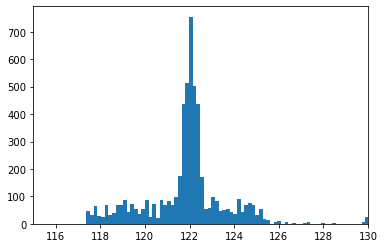

In [25]:
m = 0.040862505104599725
b = -0.1689243143849808
calib = m*tb_out['trapEmax'].nda + b
plt.hist(calib,bins=300);
plt.xlim(115,130)
plt.yscale('linear')

print(len(calib))

In [6]:
# TODO 
# turn James's fit_peak into a fom
# pass fit_peak to run_on

def peak_width(tb, verbosity, make_plot=False):

    m = 0.0428
    b = -0.193
    calib = m*tb['trapEmax'].nda + b

    binning = np.linspace(30,50,num=30000)
    
    energy = copy.deepcopy(calib)
    #counts, bins, bars = plt.hist(energy, histtype='step', bins=100000)
    counts, bins = np.histogram(energy,bins=binning)

    lower = hA.find_nearest_bin(bins,30)
    upper = hA.find_nearest_bin(bins,50)
    ydata = counts[lower:upper]
    xdata = bins[lower:upper]

    gmodel = Model(fM.linDubGaus)
    i = np.argmax(ydata)
    #params = gmodel.make_params(A=700, m1=315.5, s1=0.5, H_tail=-0.000001, H_step=1, tau=-0.5, slope=-6, intrcpt=180)
    params = gmodel.make_params(a1=400, m1=xdata[i], s1=0.07, a2=400, m2=xdata[i]+0.2, s2=0.07, slope=-0.046, intrcpt=58)
    #params['s1'].vary = False
    result = gmodel.fit(ydata,params, x=xdata)

    sigma1 = result.params['s1'].value
    fw1 = 2.355*sigma1
    sigma2 = result.params['s2'].value
    fw2 = 2.355*sigma2
    energy = result.params['m1'].value
    print(fw1)
    print(fw2)




    """
    gmodel = Model(fM.lingaus)
    i = np.argmax(ydata)
    #params = gmodel.make_params(A=700, m1=315.5, s1=0.5, H_tail=-0.000001, H_step=1, tau=-0.5, slope=-6, intrcpt=180)
    params = gmodel.make_params(a1=1000, m1=xdata[i], s1=0.1, slope=-0.046, intrcpt=0)
    #params['s1'].vary = False
    result = gmodel.fit(ydata,params, x=xdata)
    

    sigma = result.params['s1'].value
    fw = 2.355*sigma
    energy = result.params['m1'].value
    """

    
    
    if make_plot:
        print(fw1)
        print(result.fit_report())
        plt.hist(calib, histtype='step', bins=binning)
        #plt.xlim(115, 125)
        #plt.ylim(0,00)
        plt.xlabel("Energy [keV]")
        plt.plot(xdata, result.best_fit, 'r-', label='best fit')
        plt.title("Fit of 1724 Pulser FWHM")
        plt.show()

    return fw1

In [9]:
rise_arr = np.linspace(6,10,4)
flat_arr = np.linspace(0.5,0.8,3)

rr, ff = np.meshgrid(rise_arr, flat_arr)
zz = np.zeros_like(rr)


for i,flat in enumerate(flat_arr):
    for j,rise in enumerate(rise_arr):
        flat_units = str(flat)+'*us'
        rise_units = str(rise)+'*us'
        args = ['sub1',rise_units,flat_units,'wf_trap']
        dsp_config['processors']['wf_trap']['args'] = args

        fom = run_one_dsp(tb_wfs, dsp_config,fom_function=peak_width, verbosity=True)

        zz[i,j] = fom





I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!
I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1453151709906815
0.1649618232656283


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.13646306227836158
0.17450011358771392


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.13957006010929077
0.15248663764490572


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.13905839633482134
0.14568306975942313


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1465198921124803
0.16254574428651036


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1376225892682658
0.1720727427063442


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1400731613579515
0.15209487929422164


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.13958602687600355
0.14573719588491488


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1469451760471859
0.16378235980733752


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.1387937774784472
0.17087887042919417


I don't know what to do with bl_intercept. Building output without it!
I don't know what to do with bl_std. Building output without it!


0.140473924231241
0.1530757605686483
0.13979039741185115
0.14670187990680275


Text(33.0, 0.5, 'flat time [us]')

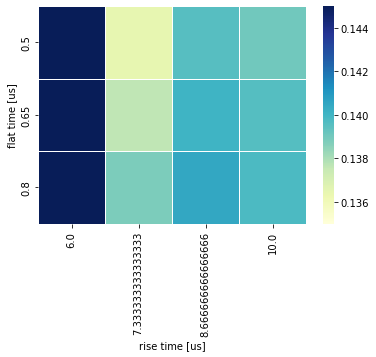

In [11]:
import seaborn as sns
sns.set_theme

x_axis_labels = rise_arr
y_axis_labels = flat_arr

ax = sns.heatmap(zz,vmin=0.135,vmax=0.145,linewidths=0.5,cmap="YlGnBu",xticklabels=x_axis_labels,yticklabels=y_axis_labels)
ax.set_xlabel('rise time [us]')
ax.set_ylabel('flat time [us]')


In [86]:
zz

array([[0.65985367, 0.62757357, 0.61536467, 0.6096737 , 0.62770978],
       [0.66009115, 0.62409992, 0.61197224, 0.61915409, 0.62882018],
       [0.65282971, 0.6188371 , 0.615222  , 0.62631445, 0.63715769],
       [0.6350284 , 0.61684482, 0.62422735, 0.63135812, 0.6421066 ],
       [0.62391004, 0.62324805, 0.63472141, 0.63423118, 0.64886411]])

In [90]:
flat_units = str(15)+'*us'
rise_units = str(15)+'*us'
args = ['wf_mw',rise_units,flat_units,'wf_trap']
dsp_config['processors']['wf_trap']['args'] = args


optSto = LH5Store("../data/raw/opt")
tb_wfs, nwfs = optSto.read_object('Card1/',"Run17.lh5")
tb_out = run_one_dsp(tb_wfs, dsp_config, db_dict=dsp_db, verbosity=True)

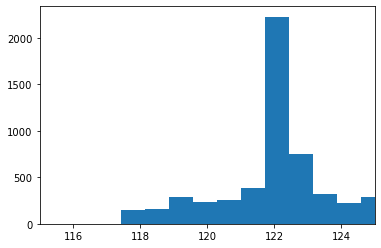

In [91]:
m = 0.040862505104599725
b = -0.1689243143849808
calib = m*tb_out['trapEmax'].nda + b
plt.hist(calib,bins=300);
plt.xlim(115,125)
plt.yscale('linear')

0.60967370093961
[[Model]]
    Model(lingaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 299
    # variables        = 5
    chi-square         = 38935.5700
    reduced chi-square = 132.433911
    Akaike info crit   = 1465.89676
    Bayesian info crit = 1484.39898
[[Variables]]
    a1:       133.715106 +/- 3.86429073 (2.89%) (init = 1000)
    m1:       122.207563 +/- 0.00851300 (0.01%) (init = 122.1237)
    s1:       0.25888480 +/- 0.00889579 (3.44%) (init = 0.1)
    slope:    1.57515483 +/- 0.24251040 (15.40%) (init = -0.046)
    intrcpt: -180.264704 +/- 29.0199446 (16.10%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intrcpt) = -1.000
    C(a1, s1)         = -0.493
    C(s1, slope)      = -0.193
    C(s1, intrcpt)    = 0.187
    C(a1, slope)      = -0.114
    C(a1, intrcpt)    = 0.111


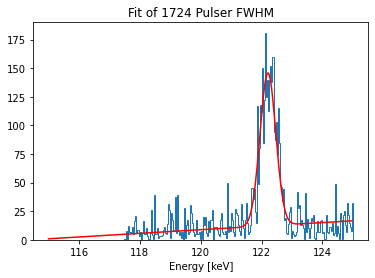

0.60967370093961

In [92]:
peak_width(tb_out,1,True)